In [2]:
import os
import random
import numpy as np
import pandas as pd  # Added import
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Set the main dataset directory and other parameters
dataset_dir = 'DATASET'
input_shape = (150, 150, 3)
num_classes = len(os.listdir(dataset_dir))
batch_size = 32
epochs = 50
test_size = 0.2

In [4]:
# Get the list of all image files
image_files = []
labels = []
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        for file_name in os.listdir(label_dir):
            image_files.append(os.path.join(label_dir, file_name))
            labels.append(label)

# Perform train-test split
train_files, validation_files, train_labels, validation_labels = train_test_split(
    image_files, labels, test_size=test_size, stratify=labels, random_state=42
)
# Preprocess images to correct rotation (portrait orientation)
# for file_path in train_files + validation_files:
#     img = Image.open(file_path)
#     width, height = img.size
#     if width > height:  # Landscape orientation
#         img = img.transpose(Image.ROTATE_90)
#         img.save(file_path)

Found 1414 validated image filenames belonging to 26 classes.
Found 354 validated image filenames belonging to 26 classes.


d:\TEKKOM UB\Bangkit 2023\Capstone\Indonesian-Sign-Language-ISL-\.venv\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


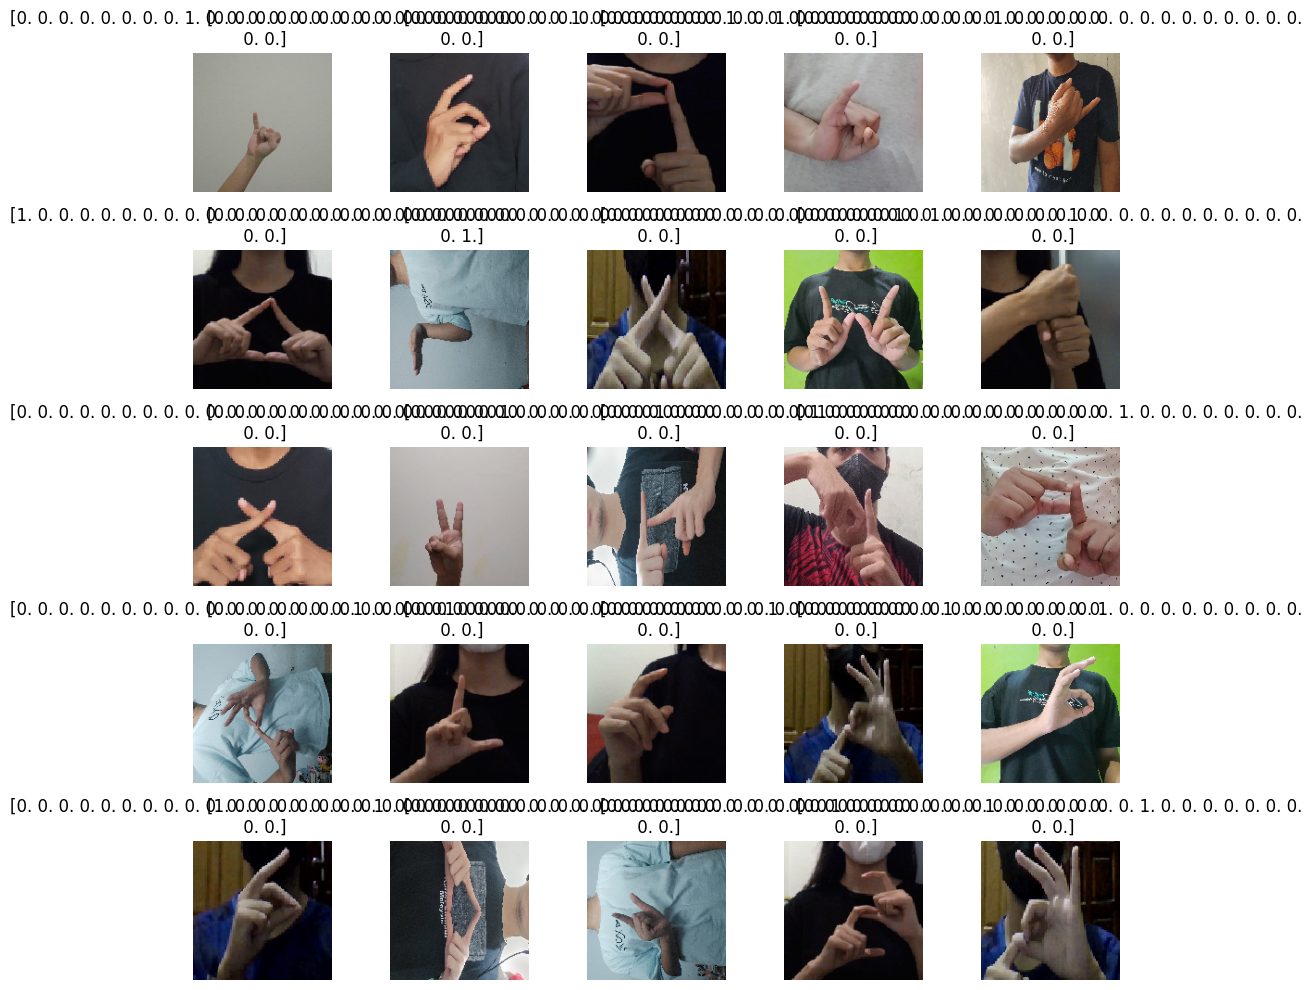

In [5]:
# Create image data generator with augmentation
datagen = ImageDataGenerator(
                                rescale=1/255,
                                # zoom_range=0.1,
                                # # width_shift_range=0.2,
                                # # height_shift_range=0.2,
                                # shear_range=0.2
)

# Generate training and validation data
train_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'label': train_labels}),
    x_col='filename',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': validation_files, 'label': validation_labels}),
    x_col='filename',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)
# Display sample data
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(sample_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Define callback to stop training if accuracy exceeds 90%
class AccuracyThresholdCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.97 :
            print("\nReached 90% validation accuracy. Stopping training.")
            self.model.stop_training = True

In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[AccuracyThresholdCallback()]
)

# Save the trained model
model.save('image_classifier_model.h5')

Epoch 1/50
44/44 [==============================] - 61s 1s/step - loss: 3.2551 - accuracy: 0.0658 - val_loss: 3.1981 - val_accuracy: 0.1506
Epoch 2/50
44/44 [==============================] - 52s 1s/step - loss: 3.1015 - accuracy: 0.1669 - val_loss: 2.9751 - val_accuracy: 0.2926
Epoch 3/50
44/44 [==============================] - 54s 1s/step - loss: 2.7698 - accuracy: 0.2829 - val_loss: 2.5619 - val_accuracy: 0.4318
Epoch 4/50
44/44 [==============================] - 51s 1s/step - loss: 2.3274 - accuracy: 0.3900 - val_loss: 2.2204 - val_accuracy: 0.4403
Epoch 5/50
44/44 [==============================] - 52s 1s/step - loss: 1.9270 - accuracy: 0.4863 - val_loss: 1.9359 - val_accuracy: 0.5170
Epoch 6/50
44/44 [==============================] - 57s 1s/step - loss: 1.6645 - accuracy: 0.5528 - val_loss: 1.7308 - val_accuracy: 0.5682
Epoch 7/50
44/44 [==============================] - 56s 1s/step - loss: 1.3735 - accuracy: 0.6491 - val_loss: 1.6080 - val_accuracy: 0.5824
Epoch 8/50
44/44 [==

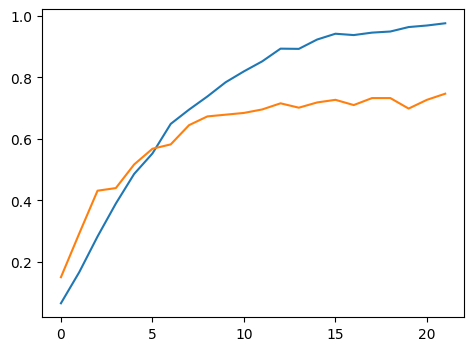

In [12]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')